# Import Modules

In [87]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pathlib
import os
import time
import numpy as np

# Ensure GPU Is Connected To Tensorflow To Increase Training Speed

In [88]:
len(tf.config.list_physical_devices('GPU'))

1

# Create Datasets

In [89]:
#Get number of images in dataset
data_dir = pathlib.Path("./archive/raw-img")
image_count = len(list(data_dir.glob('*/*')))

#Constants
#Size of image in AlexNet Model
IMAGE_HEIGHT = 227           
IMAGE_WIDTH = 227

BATCH_SIZE = 32

#Number of animals in dataset
output_class_units = 10

#Obtain all images to be used as data from dataset
all_data = tf.keras.utils.image_dataset_from_directory(
    directory="archive/raw-img",
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    label_mode='categorical')

size = len(all_data)

#Training: 80%, Validation: 10%, Testing: 10%
training_size = int(.8 * size)
validation_size = int(.1 * size)

training_data = all_data.take(training_size)
validation_data = all_data.skip(training_size).take(validation_size)
testing_data = all_data.skip(training_size + validation_size).take(size - training_size - validation_size)

Found 26179 files belonging to 10 classes.


# Create AlexNet Model

In [90]:
alexNet = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(96, (11,11),strides=(4,4), activation='relu', input_shape=(227, 227, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2,2)),
  tf.keras.layers.Conv2D(256, (11,11),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(384, (3,3),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(384, (3,3),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dense(output_class_units, activation='softmax')
])

In [91]:
# Using stochastic gradiant descent as optimizer
alexNet.compile(optimizer='sgd', loss="categorical_crossentropy", metrics=['accuracy'])

# Display model for AlexNet
alexNet.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization_65 (Bat  (None, 55, 55, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 27, 27, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_66 (Conv2D)          (None, 27, 27, 256)       2973952   
                                                                 
 batch_normalization_66 (Bat  (None, 27, 27, 256)      1024      
 chNormalization)                                                
                                                     

# Create Callback To Avoid Overtraining

In [92]:
#Callback class to avoid overtraining
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Training AlexNet

In [93]:
# Uses 30 Epochs but stops itself if loss doesn't improve 3 epochs in a row
history = alexNet.fit(training_data, epochs=30, validation_data=validation_data, callbacks=[callbacks], use_multiprocessing=True)

# Saving the model so that training does not have to occur multiple times.
alexNet.save('Blake_Del_Rey_AlexNet')

Epoch 1/30
655/655 [==============================] - 72s 108ms/step - loss: 1.8683 - accuracy: 0.3911 - val_loss: 1.8586 - val_accuracy: 0.3472
Epoch 2/30
655/655 [==============================] - 73s 112ms/step - loss: 1.2030 - accuracy: 0.5884 - val_loss: 1.3758 - val_accuracy: 0.5463
Epoch 3/30
655/655 [==============================] - 69s 105ms/step - loss: 0.7399 - accuracy: 0.7559 - val_loss: 1.2022 - val_accuracy: 0.6049
Epoch 4/30
655/655 [==============================] - 69s 105ms/step - loss: 0.3408 - accuracy: 0.9049 - val_loss: 1.7154 - val_accuracy: 0.5258
Epoch 5/30
655/655 [==============================] - 69s 105ms/step - loss: 0.1143 - accuracy: 0.9784 - val_loss: 1.9255 - val_accuracy: 0.5104
Epoch 6/30
655/655 [==============================] - 69s 105ms/step - loss: 0.0481 - accuracy: 0.9932 - val_loss: 1.3294 - val_accuracy: 0.6427
Epoch 7/30
655/655 [==============================] - 69s 105ms/step - loss: 0.0241 - accuracy: 0.9976 - val_loss: 1.4097 - val_ac

# Evaluate Performance of AlexNet Model

In [149]:
score = alexNet.evaluate(testing_data)

83/83 [==============================] - 14s 35ms/step - loss: 1.5705 - accuracy: 0.6719


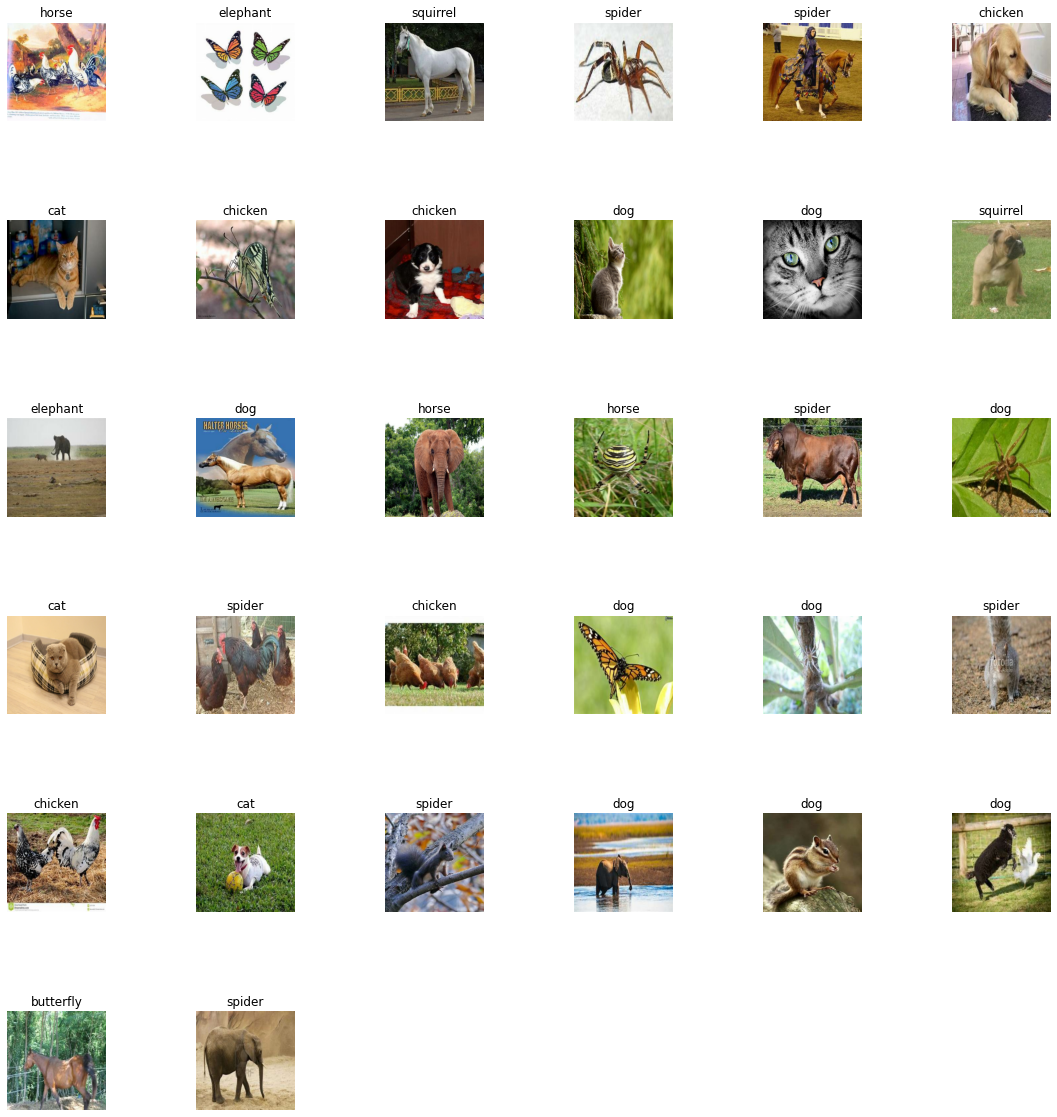

In [152]:
from math import sqrt
import random
translate = {"ragno": "spider", "cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "dog": "cane", "cavallo": "horse", "elephant" : "elefante", "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo"}

# Make a prediction of random batch in testing data.
prediction_data = testing_data.skip(random.randint(0, len(testing_data) - 1)).take(1)
prediction = np.argmax(alexNet.predict(prediction_data), axis=-1)
class_names = all_data.class_names

#Make Plot Big Enough For Testing Data pictures to be visible
plt.rcParams["figure.figsize"] = (20,20)

# Display prediction.
for images, labels in prediction_data:
    for i in range(BATCH_SIZE):
        ax = plt.subplot(int(sqrt(BATCH_SIZE)) + 1, int(sqrt(BATCH_SIZE)) + 1, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(translate[class_names[prediction[i]]])
        plt.axis("off")

plt.subplots_adjust(wspace=0.1, hspace=1.0)
plt.show()